In [1]:
%load_ext autoreload
%autoreload 2

0. get input data
1. convert current augmentation to numpy/cupy 
    1. non-elliptical part
    2. for elliptical, use py4dstem elliptical transform method 
2. confirm working more or less like original
    1. script in https://github.com/AI-ML-4DSTEM/4D-PREP/blob/main/data_handler/data_handler.py 
3. add subpixel shifting 
    1. first plane wave
    2. then gaussian/nonlinear 

In [2]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from augment4D.augment import Image_Augmentation

In [3]:
from hipl.utils import show_im

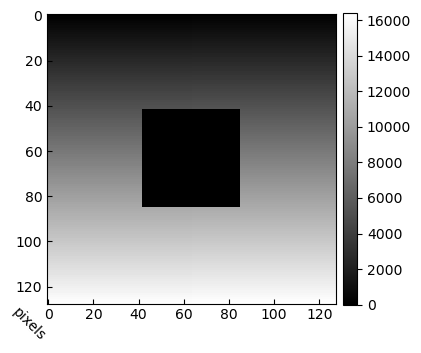

In [5]:
dy = dx = 128
a = np.arange(dy*dx).reshape((dy, dx))
a[dy//3:2*dy//3, dx//3:2*dx//3] = 0
show_im(a)

In [16]:
augmentor = Image_Augmentation(
    background=False,
    shot=False,
    pattern_shift=True,
    xshift=16,
    yshift=16,
    counts_per_pixel=1e3,
    qBackgroundLorentz=0.1,
    weightbackground=0.1,
    scale=1.0,
    verbose=True,
    log_file="./logs/log1.csv",
    device='cpu',
)

In [17]:
im2 = augmentor.augment_img(a[None,...])

show_im(im2)
print(np.all(a==im2))

ValueError: not enough values to unpack (expected 4, got 3)

In [8]:
a = np.arange(10)
b = cp.arange(10)+10

a.ndim

1

In [15]:
np.fft.fftfreq(10, d=0.5)

array([ 0. ,  0.2,  0.4,  0.6,  0.8, -1. , -0.8, -0.6, -0.4, -0.2])

In [30]:

def _get_qx_qy(input_shape, pixel_size_AA = 0.20):
    """
    get qx,qy from cbed
    """
    N = input_shape
    qx = np.sort(np.fft.fftfreq(N[0], pixel_size_AA)).reshape((N[0], 1, 1))
    qy = np.sort(np.fft.fftfreq(N[1], pixel_size_AA)).reshape((1, N[1], 1))

    return qx, qy

def _make_fourier_coord(Nx, Ny, pixelSize):
    """
    Generates Fourier coordinates for a (Nx,Ny)-shaped 2D array.
    Specifying the pixelSize argument sets a unit size.
    """
    if hasattr(pixelSize, '__len__'):
        assert len(pixelSize) == 2, "pixelSize must either be a scalar or have length 2"
        pixelSize_x = pixelSize[0]
        pixelSize_y = pixelSize[1]
    else:
        pixelSize_x = pixelSize
        pixelSize_y = pixelSize

    qx = np.fft.fftfreq(Nx, pixelSize_x)
    qy = np.fft.fftfreq(Ny, pixelSize_y)
    qy, qx = np.meshgrid(qy, qx)
    return qx, qy

In [31]:
qx, qy = _make_fourier_coord(100,100, 0.2)

qx.shape

(100, 100)

In [48]:
cp.asarray(np.arange(10))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [54]:
a = np.arange(5)
b = 3

a = np.expand_dims(a, axis=0)
a = np.repeat(a, b, axis=0)
a = np.expand_dims(a, axis=-1)
a = np.repeat(a, 2, axis=0)

a.shape

(6, 5, 1)

In [55]:
np.

array([[[0],
        [1],
        [2],
        [3],
        [4]],

       [[0],
        [1],
        [2],
        [3],
        [4]],

       [[0],
        [1],
        [2],
        [3],
        [4]],

       [[0],
        [1],
        [2],
        [3],
        [4]],

       [[0],
        [1],
        [2],
        [3],
        [4]],

       [[0],
        [1],
        [2],
        [3],
        [4]]])